In [11]:
import pandas as pd
import numpy as np

In [12]:
D = pd.read_csv("/Users/jrock/Documents/Yonsei/DSL/EDA/AirDNA-20220817/Processed_1.csv") 

In [13]:
new_column = D['Airbnb Response Time (Text)'].copy()
D.insert(D.columns.get_loc('Airbnb Response Time (Text)')+1, 'Response Time_new', new_column)

In [14]:
D['Response Time_new'] = D['Response Time_new'].replace('within an hour', 4)
D['Response Time_new'] = D['Response Time_new'].replace('within a few hours', 3)
D['Response Time_new'] = D['Response Time_new'].replace('within a day', 2)
D['Response Time_new'] = D['Response Time_new'].replace('a few days or more', 1)

In [6]:
D['Response Time_new'].unique()

array([nan,  3.,  4.,  1.,  2.])

In [1]:
#essentials
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
#tools/metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import shap

In [15]:
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78425 entries, 0 to 78424
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Property Type                 69927 non-null  object 
 1   Listing Type                  78384 non-null  object 
 2   Created Date                  76000 non-null  float64
 3   Last Scraped Date             78425 non-null  object 
 4   Neighborhood                  78349 non-null  object 
 5   Average Daily Rate (USD)      15583 non-null  float64
 6   Annual Revenue LTM (USD)      72660 non-null  float64
 7   Occupancy Rate LTM            24036 non-null  float64
 8   Number of Bookings LTM        78425 non-null  int64  
 9   Number of Reviews             77854 non-null  float64
 10  Bedrooms                      78341 non-null  float64
 11  Bathrooms                     78199 non-null  float64
 12  Max Guests                    78267 non-null  float64
 13  C

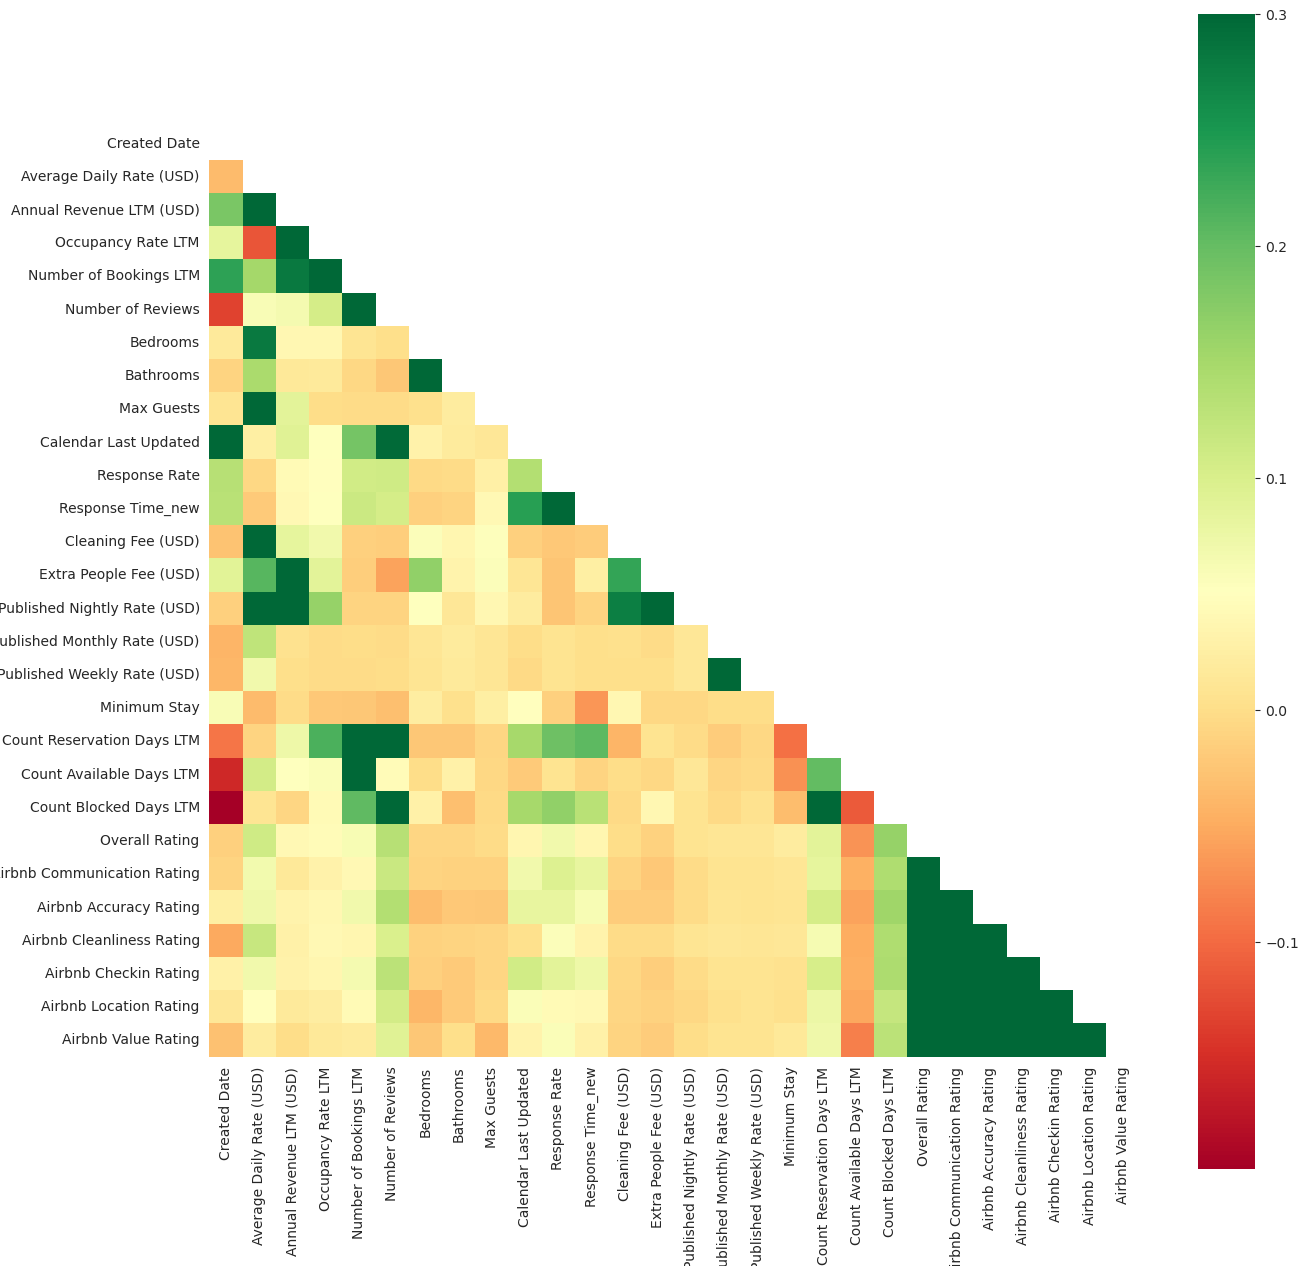

In [16]:
#correlations of each features
corr_matrix = D.corr()

#plot heat map
mask = np.zeros_like(corr_matrix)

mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr_matrix, mask=mask, vmax=.3, square=True,cmap="RdYlGn")

Mutual Information

Mutual information is a function measuring association between feature and target, which may seem similar to correlation which detects linear relationships. However, this metric is able to detect any kind of relationship (and not just linear).

The disclaimer on mutual information is that the features that score high do not always impact the model performance. The usefulness of mutual information can vary depending on type of model.


Mutual Information은 머신러닝과 통계학에서 두 변수 간의 상관 관계를 측정하는 지표입니다. 이는 한 변수가 다른 변수를 얼마나 잘 설명하거나 예측할 수 있는지를 나타냅니다. 두 변수 사이의 종속성을 측정하는 데 사용됩니다.

상호 정보량은 엔트로피(무질서도)의 변화를 기반으로 합니다. 두 변수 간의 상호 의존성이 클수록 상호 정보량은 높아지며, 한 변수의 정보가 다른 변수의 정보를 얼마나 잘 설명하는지를 나타냅니다.

특히, 이 지표는 범주형 변수 사이의 상관 관계를 측정하는 데 유용합니다. 예를 들어, 두 범주형 변수 사이의 관계를 파악하거나, 변수 간의 연관성을 알아내는 데 사용됩니다. 상호 정보량은 두 변수가 동시에 가질 수 있는 정보의 양을 측정하여 이를 기반으로 변수 간의 연관성을 평가합니다.

높은 상호 정보량은 두 변수가 서로 밀접하게 연관되어 있음을 나타내며, 낮은 상호 정보량은 두 변수 간의 연관성이 적거나 없음을 나타냅니다. 이를 통해 변수 간의 관련성을 파악하고, 예측 모델에 유용한 변수를 식별하는 데 활용됩니다.

In [ ]:
D1 = D.dropna()

In [27]:
def calculate_ml_scores(df):
    X =df.copy()
    y = X["Occupancy Rate LTM"]

    X.drop('Occupancy Rate LTM', axis=1, inplace=True)

    # Label encoding for categoricals #범주형자료를 숫자형으로 변환
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int
    

    #입력변수 X와 종속변수 y 간의 상호 정보량 계산 --> 입력변수가 종속변수에 대해 얼마나 유용한 정보를 제공하는지 측정
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores

In [28]:
X, y, mi_scores = calculate_ml_scores(df=D1)

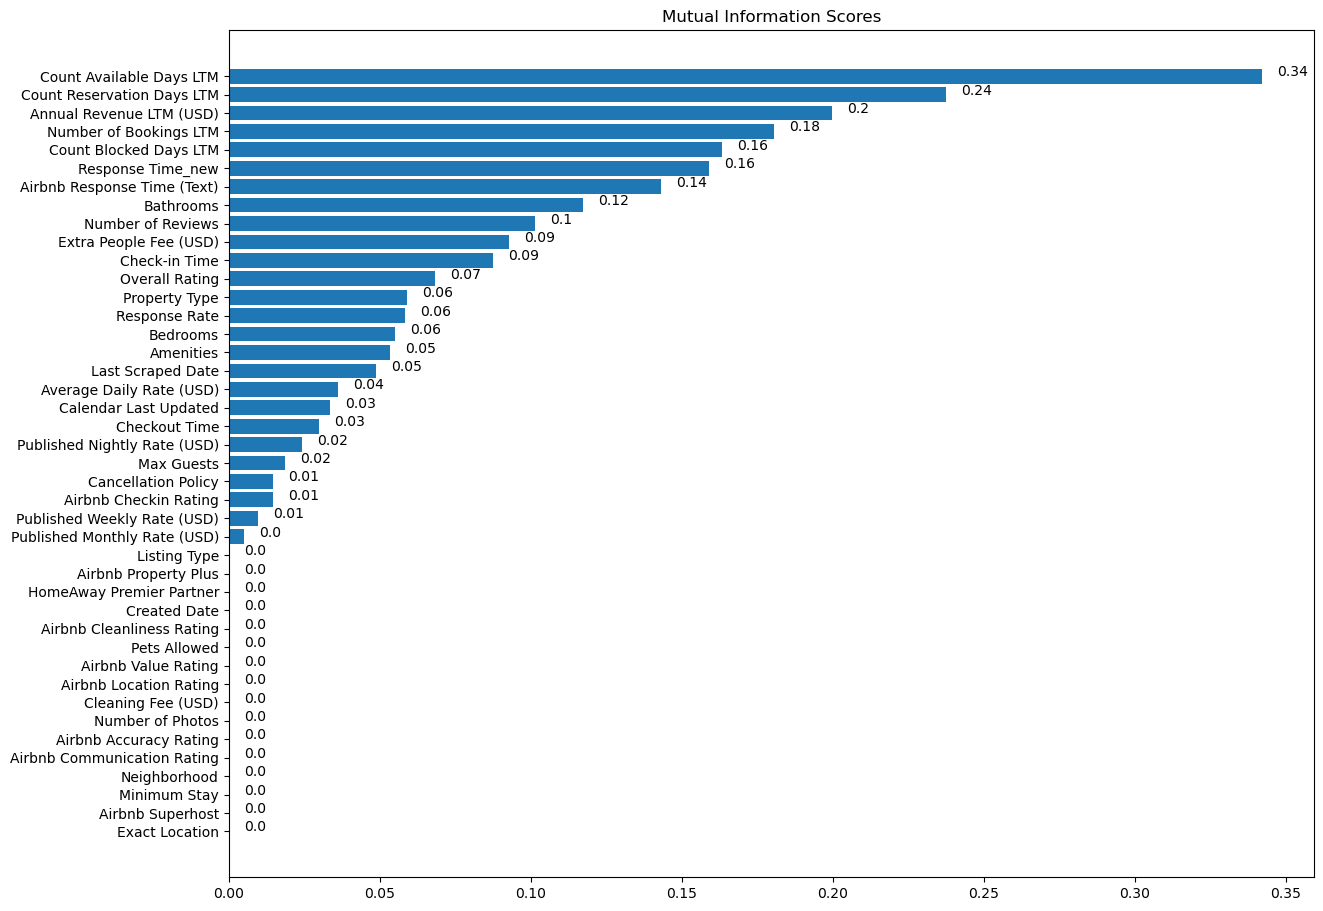

In [29]:
def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores, figsize=(14,11))